Turbocharged demo
==

We demonstrate the rough Bergomi (rBergomi) price process introduced by [Bayer, Friz and Gatheral](https://ssrn.com/abstract=2554754), which we define here by

$$S_t := \exp \left\{ \int_0^t \sqrt{ V_u } \mathrm{d}B_u - \frac{1}{2}\int_0^t V_u \mathrm{d}u \right\},\quad B_u:=\rho W_u^1 + \sqrt{1 - \rho^2}W_u^2, $$

$$V_t := \xi\ \exp \left\{ \eta Y^a_t - \frac{\eta^2}{2} t^{2a + 1}\right\}, \quad Y_t^a := \sqrt{2a + 1} \int_0^t (t - u)^a  \mathrm{d}W^1_u,$$

for Brownian motion $(W^1, W^2)$. The *hybrid scheme* of [Bennedsen, Lunde and Pakkanen](https://arxiv.org/abs/1507.03004) is used for efficient, $\mathcal{O}(n\log n)$, simulation of the Volterra process, $Y_t^a$.

From $N$ samples of the price process, $\{S^i_t\}_{i = 1}^N$ , we show implied volatilities, $\hat{\sigma}^N_{BS}(k,t)$,  using estimators of the form

$$\hat{\sigma}^N_{BS}(k,t)^2 t = BS^{-1}\left(\hat{C}_N(k,t)\right),\quad \hat{C}_N(k,t) = \frac{1}{N}\sum_{i = 1}^N (X_i + c Y_i) - c\mathbb{E}[Y],$$

as described in [McCrickerd and Pakkanen](https://arxiv.org/abs/1708.02563). For simplicity, we just use call option estimators (rather than OTM option estimators) and do not use antithetic sampling here.

We thus define a Base estimator here by $$X = \max(S_t - e^k,0),\quad Y = 0$$ and a Mixed estimator by $$X = BS\left((1 - \rho^2)\int_0^t V_u\mathrm{d}u; S^1_t,k\right),\quad Y = BS\left(\rho^2\left(Q - \int_0^t V_u\mathrm{d}u\right); S^1_t,k\right)$$

where $S^1_t$ is the parallel component of the price process, defined by $$S^1_t := \exp \left\{ \rho\int_0^t \sqrt{ V_u } \mathrm{d}W^1_u - \frac{\rho^2}{2}\int_0^t V_u \mathrm{d}u \right\}.$$

While most computations are hidden in the methods of the rBergomi class, we expose the Mixed estimator calculations in this notebook for transparency.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from rbergomi import rBergomi
from utils import bs, bsinv
vec_bsinv = np.vectorize(bsinv)

Create instance of the rBergomi class with $n$ steps per year, $N$ paths, maximum maturity $T$ and roughness index $a$

In [3]:
rB = rBergomi(n = 312*4, N = 1000, T = 0.25, a = -0.43)

Fix the generator's seed for replicable results

In [4]:
np.random.seed(0)

Generate required Brownian increments

In [5]:
dW1 = rB.dW1()
dW2 = rB.dW2()

In [7]:
dW1.shape

(1000, 312, 2)

In [8]:
dW2.shape

(1000, 312)

Construct the Volterra process, $$Y_t^a := \sqrt{2a + 1} \int_0^t (t - u)^a  \mathrm{d}W^1_u$$

In [9]:
Ya = rB.Y(dW1)

In [10]:
Ya.shape

(1000, 313)

Correlate the orthogonal increments, using $\rho$, $$B_u:=\rho W_u^1 + \sqrt{1 - \rho^2}W_u^2$$

In [11]:
dB = rB.dB(dW1, dW2, rho = -0.9)

In [12]:
dB.shape

(1000, 312)

Construct the variance process, using $\xi$ and $\eta$, $$V_t := \xi\ \exp \left\{ \eta Y^a_t - \frac{\eta^2}{2} t^{2a + 1}\right\}$$

In [13]:
V = rB.V(Ya, xi = 0.235**2, eta = 1.9) 

In [14]:
V.shape

(1000, 313)

Finally construct the price processes, $$S_t := \exp \left\{ \int_0^t \sqrt{ V_u } \mathrm{d}B_u - \frac{1}{2}\int_0^t V_u \mathrm{d}u \right\},\quad S^1_t := \exp \left\{ \rho\int_0^t \sqrt{ V_u } \mathrm{d}W^1_u - \frac{\rho^2}{2}\int_0^t V_u \mathrm{d}u \right\}$$

In [15]:
S = rB.S(V, dB)
S1 = rB.S1(V, dW1, rho = -0.9)

In [16]:
S.shape

(1000, 313)

In [17]:
S1.shape

(1000, 313)

Now set log-strikes, $k$

In [18]:
k = np.array([-0.1787,0.0000,0.1041])
K = np.exp(k)[np.newaxis,:]

and known implied volatilities for this model specification

In [19]:
implied_vols = np.array([0.2961,0.2061,0.1576])[:,np.newaxis]

In [20]:
implied_vols.shape

(3, 1)

Compute Base call payoffs, prices, and estimated volatilities,

In [21]:
ST = S[:,-1][:,np.newaxis]
base_payoffs = np.maximum(ST - K,0)
base_prices = np.mean(base_payoffs, axis = 0)[:,np.newaxis]
base_vols = vec_bsinv(base_prices, 1., np.transpose(K), rB.T)

Do the same for the Mixed estimator, including the quadratic variation, $\mathrm{QV} = \int_0^t V_u \mathrm{d}u$, and variation budget, $\mathrm{Q}$

In [22]:
QV = np.sum(V, axis = 1)[:,np.newaxis] * rB.dt
Q = np.max(QV) + 1e-9 

$$X = BS\left((1 - \rho^2)\int_0^t V_u\mathrm{d}u; S^1_t,k\right),\quad Y = BS\left(\rho^2\left(Q - \int_0^t V_u\mathrm{d}u\right); S^1_t,k\right)$$

In [23]:
S1T = S1[:,-1][:,np.newaxis]
X = bs(S1T, K, (1 - rB.rho**2) * QV)
Y = bs(S1T, K, rB.rho**2 * (Q - QV))
eY = bs(1., K, rB.rho**2 * Q)

# Asymptotically optimal weights
c = np.zeros_like(k)[np.newaxis,:]
for i in range(len(k)):
    cov_mat = np.cov(X[:,i], Y[:,i])
    c[0,i] = - cov_mat[0,1] / cov_mat[1,1]

# Payoffs, prices and volatilities
mixed_payoffs = X + c * (Y - eY)
mixed_prices = np.mean(mixed_payoffs, axis = 0)[:,np.newaxis]
mixed_vols = vec_bsinv(mixed_prices, 1., np.transpose(K), rB.T)

Now plot implied volatilities against Base and Mixed estimators

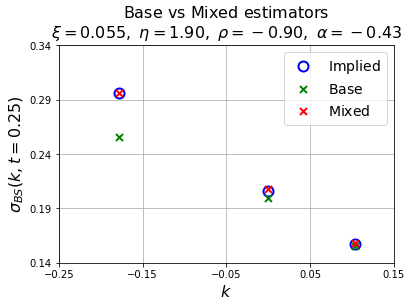

In [24]:
plot,axes = plt.subplots()
# Add Implied, Base and Mixed vols
axes.plot(k, implied_vols, 'bo', fillstyle = 'none', ms = 10, mew = 2)
axes.plot(k, base_vols, 'gx', ms = 7, mew = 2)
axes.plot(k, mixed_vols, 'rx', ms = 7, mew = 2)
# Label figure
axes.set_xlabel(r'$k$',fontsize=16)
axes.set_ylabel(r'$\sigma_{BS}(k,t=%.2f)$'%rB.T,fontsize=16)
title1 = r'$\mathrm{Base\ vs\ Mixed\ estimators}$'
title2 = r'$\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ \alpha=%.2f $'
axes.set_title(title1+'\n'+title2%(rB.xi,rB.eta,rB.rho,rB.a), fontsize=16)
axes.legend([r'$\mathrm{Implied}$',r'$\mathrm{Base}$',r'$\mathrm{Mixed}$'], fontsize=14)
# Set scale to match paper
set_scale = True
if set_scale:
    xmin,xmax = -0.25,0.15
    ymin,ymax =  0.14,0.34
    nticks = 5
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    axes.xaxis.set_ticks(np.linspace(xmin,xmax,nticks))
    axes.yaxis.set_ticks(np.linspace(ymin,ymax,nticks))
plt.grid(True)

Please do not attempt to draw conclusions regarding the relative performance of the Base and Mixed estimators from just one (or several) simulation(s) / seed(s) !